# Import Library and Tools

In [211]:
### Import Library
import os
import obspy
import re
import pywt
import pickle as pkl

import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from skimage.restoration import (denoise_wavelet, estimate_sigma)

import tensorflow as tf
import keras
import keras.backend as K

import folium

### Tools
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


# Load Data

## Load SACA and BH File

### Load SACA

In [212]:
file_path = './Data/2022-05-16-mww58-southern-sumatra-indonesia'

In [213]:
list_file = os.listdir(file_path)
list_file_saca = [filename for filename in list_file if os.path.isfile(os.path.join(file_path, filename))]

total_file_sample = 180
print(f'total SACA file: {len(list_file_saca)}\n')
temp = '\n'.join(list_file_saca[:total_file_sample])
print(f'{total_file_sample} sample of SACA file:\n{temp}')

total SACA file: 337

180 sample of SACA file:
BK.CMB.00.BHE.Q.2022.136.190418.SAC
BK.CMB.00.BHN.Q.2022.136.190418.SAC
BK.CMB.00.BHZ.Q.2022.136.190418.SAC
CI.PASC.00.BHE.D.2022.136.190432.SAC
CI.PASC.00.BHN.D.2022.136.190432.SAC
CI.PASC.00.BHZ.D.2022.136.190432.SAC
CI.PASC.10.BHE.D.2022.136.190432.SAC
CI.PASC.10.BHN.D.2022.136.190432.SAC
CI.PASC.10.BHZ.D.2022.136.190432.SAC
CU.BBGH.00.BH1.M.2022.136.190821.SAC
CU.BBGH.00.BH2.M.2022.136.190821.SAC
CU.BBGH.00.BHZ.M.2022.136.190821.SAC
CU.GRTK.00.BH1.M.2022.136.190824.SAC
CU.GRTK.00.BH2.M.2022.136.190824.SAC
CU.GRTK.00.BHZ.M.2022.136.190824.SAC
CU.SDDR.00.BH1.M.2022.136.190826.SAC
CU.SDDR.00.BH2.M.2022.136.190826.SAC
CU.SDDR.00.BHZ.M.2022.136.190826.SAC
GT.VNDA.00.BHE.M.2022.136.190024.SAC
GT.VNDA.00.BHN.M.2022.136.190024.SAC
GT.VNDA.00.BHZ.M.2022.136.190024.SAC
IC.ENH.00.BH1.M.2022.136.185526.SAC
IC.ENH.00.BH2.M.2022.136.185526.SAC
IC.ENH.00.BHZ.M.2022.136.185526.SAC
IC.ENH.60.BH1.M.2022.136.185526.SAC
IC.ENH.60.BH2.M.2022.136.185526.SAC

## Example SAC data

In [214]:
test1 = obspy.read(os.path.join(file_path, list_file_saca[3]), format='SAC')
test2 = obspy.read(os.path.join(file_path, list_file_saca[18]), format='SAC')
print(test1[0].stats)
print('=========================')
print(test2[0].stats)


         network: CI
         station: PASC
        location: 00
         channel: BHE
       starttime: 2022-05-16T19:04:32.994500Z
         endtime: 2022-05-16T19:48:13.994500Z
   sampling_rate: 40.0
           delta: 0.025
            npts: 104841
           calib: 4500990000.0
         _format: SAC
             sac: AttribDict({'delta': 0.025, 'scale': 4500990000.0, 'b': 0.0005, 'e': 2621.0005, 'o': -367.9945, 'stla': 34.17141, 'stlo': -118.18523, 'stel': 341.0, 'stdp': 0.0, 'evla': -5.245, 'evlo': 102.0077, 'evdp': 23.0, 'dist': 14783.829, 'az': 46.98279, 'baz': 298.5732, 'gcarc': 132.96005, 'cmpaz': 90.0, 'cmpinc': 90.0, 'nzyear': 2022, 'nzjday': 136, 'nzhour': 19, 'nzmin': 4, 'nzsec': 32, 'nzmsec': 994, 'nvhdr': 6, 'npts': 104841, 'iftype': 1, 'leven': 1, 'kstnm': 'PASC', 'kevnm': 'SouthernSumatra', 'khole': '00', 'kcmpnm': 'BHE', 'knetwk': 'CI', 'kinst': 'STS-1 HO'})
         network: GT
         station: VNDA
        location: 00
         channel: BHE
       starttime: 2022-05

<class 'numpy.ndarray'>
104841
[-17607. -17375. -17361. ... -15348. -14857. -17223.]


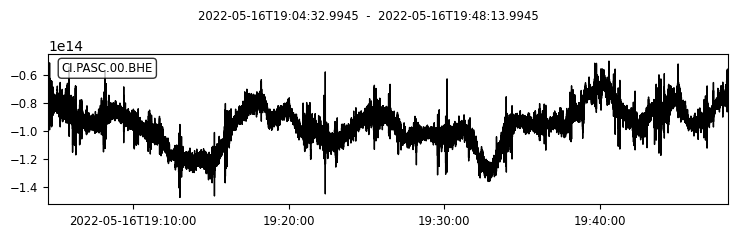

Figure(800x250)


In [215]:
print(type(test1[0].data))
print(len(test1[0].data))
print(test1[0].data)
print(test1.plot())

### Dataset Identity

In [216]:
df = pd.read_csv('./Data/data_identity.txt', sep='|')
print(f'total data in dataset: {len(df)}')
df.head()

total data in dataset: 69


,Station,Source,Net,Latitude,Longitude,Distance,Azimuth,Elevation,Station Name
0,BTDF,IRISDMC,MS,1.3617,103.7750,6.838478,15.006883,57.0,Bukit Timah Dairy Farm
1,COCO,IRISDMC,II,-12.1901,96.8349,8.622234,-143.996826,1.0,"West Island, Cocos (Keeling) Islands"
2,KAPI,IRISDMC,II,-5.0142,119.7517,17.673860,90.057363,300.0,"Kappang, Sulawesi, Indonesia"
3,MBWA,IRISDMC,IU,-21.1590,119.7313,23.422910,134.423008,190.0,"Marble Bar, Western Australia"
4,CHTO,IRISDMC,IU,18.8141,98.9443,24.247711,-7.075346,420.0,"Chiang Mai, Thailand"


# Data Processing

## Load Metadata and Wavelength Data, and give additional data to Metadata

### Combine Channel Filename Using 1 Location ID & Remove Uncomplete Wavelength Channel

In [217]:
wavelength_dict = {}

for index, name in enumerate(list_file_saca):       
    pattern = re.compile(r"""
    (^\w+\.\w+)\.
    (\d*)\.
    (\w+)\.
    ([\w\.]+)
    \.SAC
    """, re.VERBOSE)
    name_group = list(pattern.search(name).groups())
    wavelength_name = '_'.join([name_group[0], name_group[3]])
    wavelength_channel = name_group[2]
    
    if wavelength_name not in wavelength_dict:
        wavelength_dict[wavelength_name] = [name_group[1], [wavelength_channel]]
    elif len(wavelength_dict[wavelength_name][1]) < 3:
        wavelength_dict[wavelength_name][1].append(wavelength_channel)
        
for key, item in list(wavelength_dict.items()):
    if len(item[1]) != 3:
        del wavelength_dict[key]
        continue
    
    if item[1][0] == 'BH1':
        wavelength_dict[key][1][0], wavelength_dict[key][1][1] = wavelength_dict[key][1][1], wavelength_dict[key][1][0]

wavelength_dict

{'BK.CMB_Q.2022.136.190418': ['00', ['BHE', 'BHN', 'BHZ']],
 'CI.PASC_D.2022.136.190432': ['00', ['BHE', 'BHN', 'BHZ']],
 'CU.BBGH_M.2022.136.190821': ['00', ['BH2', 'BH1', 'BHZ']],
 'CU.GRTK_M.2022.136.190824': ['00', ['BH2', 'BH1', 'BHZ']],
 'CU.SDDR_M.2022.136.190826': ['00', ['BH2', 'BH1', 'BHZ']],
 'GT.VNDA_M.2022.136.190024': ['00', ['BHE', 'BHN', 'BHZ']],
 'IC.ENH_M.2022.136.185526': ['00', ['BH2', 'BH1', 'BHZ']],
 'IC.HIA_M.2022.136.185806': ['00', ['BH2', 'BH1', 'BHZ']],
 'IC.KMI_M.2022.136.185435': ['00', ['BH2', 'BH1', 'BHZ']],
 'IC.SSE_M.2022.136.185603': ['00', ['BH2', 'BH1', 'BHZ']],
 'IC.XAN_M.2022.136.185556': ['00', ['BH2', 'BH1', 'BHZ']],
 'II.ASCN_M.2022.136.190315': ['00', ['BH2', 'BH1', 'BHZ']],
 'II.BFO_M.2022.136.190151': ['00', ['BHE', 'BHN', 'BHZ']],
 'II.BORG_M.2022.136.190245': ['00', ['BH2', 'BH1', 'BHZ']],
 'II.BORK_M.2022.136.185857': ['10', ['BH2', 'BH1', 'BHZ']],
 'II.CMLA_M.2022.136.190347': ['00', ['BH2', 'BH1', 'BHZ']],
 'II.COCO_M.2022.136.185028': [

### Drop Dataframe Row Without SAC data

In [218]:
unusable_row_index_list = []

for index, item in df.iterrows():
    item_network = item['Net']
    item_station = item['Station']
    item_name = f'{item_network}.{item_station}'
    
    for wavelength_filename in list(wavelength_dict.keys()):
        if item_name in wavelength_filename:
#             print(f'dataset row {index} available')
            break
    else:
#         print(f'dataset row {index} not available')
        unusable_row_index_list.append(index)

df_sac_wavelength = df.drop(unusable_row_index_list)
df_sac_wavelength

,Station,Source,Net,Latitude,Longitude,Distance,Azimuth,Elevation,Station Name
1,COCO,IRISDMC,II,-12.19010,96.8349,8.622234,-143.996826,1.0,"West Island, Cocos (Keeling) Islands"
2,KAPI,IRISDMC,II,-5.01420,119.7517,17.673860,90.057363,300.0,"Kappang, Sulawesi, Indonesia"
3,MBWA,IRISDMC,IU,-21.15900,119.7313,23.422910,134.423008,190.0,"Marble Bar, Western Australia"
4,CHTO,IRISDMC,IU,18.81410,98.9443,24.247711,-7.075346,420.0,"Chiang Mai, Thailand"
5,DAV,IRISDMC,IU,7.06970,125.5791,26.551312,62.599605,151.0,"Davao, Philippines"
...,...,...,...,...,...,...,...,...,...
64,GRTK,IRISDMC,CU,21.51149,-71.1327,162.427859,-21.595544,12.0,"Grand Turk, Turks and Caicos Islands"
65,SDDR,IRISDMC,CU,18.98210,-71.2878,164.786785,-24.879595,589.0,"Presa de Sabenta, Dominican Republic"
66,PAYG,IRISDMC,IU,-0.67420,-90.2861,166.369218,115.385214,270.0,"Puerto Ayora, Galapagos Islands"
67,JTS,IRISDMC,II,10.29080,-84.9525,171.456819,53.379417,340.0,"Las Juntas de Abangares, Costa Rica"


### Create Additional Data For Dataframe

In [219]:
df_sac_wavelength_adddata = df_sac_wavelength.reindex(columns=df.columns.to_list()+
                          [
                              'Start_Time', 
                              'Station_Elevation', 'Station_Depth',
                              'Earthquake_Latitude', 'Earthquake_Longitude', 'Earthquake_Depth',
                              'Earthquake_Station_Distance', 'Back_Azimuth',
                          ]).reset_index(drop=True)
df_sac_wavelength_adddata = df_sac_wavelength_adddata.rename(columns={'Latitude': 'Station_Latitude', 'Longitude': 'Station_Longitude'})

In [220]:
for filename, attribute in list(wavelength_dict.items()):
    temp = f'.{attribute[0]}.{attribute[1][0]}.'
    filename = filename.replace('_', temp) +'.SAC'
    
    wavelength_data = obspy.read(os.path.join(file_path, filename), format='SAC')
    wavelength_stats = wavelength_data[0].stats
#     print(wavelength_stats)
    df_sac_wavelength_adddata.loc[df_sac_wavelength_adddata['Station'] == wavelength_stats['station'], 'Start_Time'] = wavelength_stats['starttime']
    df_sac_wavelength_adddata.loc[df_sac_wavelength_adddata['Station'] == wavelength_stats['station'], 'Station_Elevation'] = wavelength_stats['sac']['stel']
    df_sac_wavelength_adddata.loc[df_sac_wavelength_adddata['Station'] == wavelength_stats['station'], 'Station_Depth'] = wavelength_stats['sac']['stdp']
    df_sac_wavelength_adddata.loc[df_sac_wavelength_adddata['Station'] == wavelength_stats['station'], 'Earthquake_Latitude'] = wavelength_stats['sac']['evla']
    df_sac_wavelength_adddata.loc[df_sac_wavelength_adddata['Station'] == wavelength_stats['station'], 'Earthquake_Longitude'] = wavelength_stats['sac']['evlo']
    df_sac_wavelength_adddata.loc[df_sac_wavelength_adddata['Station'] == wavelength_stats['station'], 'Earthquake_Depth'] = wavelength_stats['sac']['evdp']
    df_sac_wavelength_adddata.loc[df_sac_wavelength_adddata['Station'] == wavelength_stats['station'], 'Earthquake_Station_Distance'] = wavelength_stats['sac']['dist']
    df_sac_wavelength_adddata.loc[df_sac_wavelength_adddata['Station'] == wavelength_stats['station'], 'Back_Azimuth'] = wavelength_stats['sac']['baz']
    

In [221]:
print(df_sac_wavelength_adddata.shape)
df_sac_wavelength_adddata.head()

(62, 17)


,Station,Source,Net,Station_Latitude,Station_Longitude,Distance,Azimuth,Elevation,Station Name,Start_Time,Station_Elevation,Station_Depth,Earthquake_Latitude,Earthquake_Longitude,Earthquake_Depth,Earthquake_Station_Distance,Back_Azimuth
0,COCO,IRISDMC,II,-12.1901,96.8349,8.622234,-143.996826,1.0,"West Island, Cocos (Keeling) Islands",2022-05-16T18:50:28.019538Z,1.0,44.799999,-5.245,102.007698,23.0,954.800049,36.965694
1,KAPI,IRISDMC,II,-5.0142,119.7517,17.673860,90.057363,300.0,"Kappang, Sulawesi, Indonesia",2022-05-16T18:52:29.019538Z,300.0,61.000000,-5.245,102.007698,23.0,1965.260376,268.468445
2,MBWA,IRISDMC,IU,-21.1590,119.7313,23.422910,134.423008,190.0,"Marble Bar, Western Australia",2022-05-16T18:53:32.019538Z,93.0,97.000000,-5.245,102.007698,23.0,2597.827881,310.139557
3,CHTO,IRISDMC,IU,18.8141,98.9443,24.247711,-7.075346,420.0,"Chiang Mai, Thailand",2022-05-16T18:53:40.019538Z,320.0,100.000000,-5.245,102.007698,23.0,2679.332520,172.510071
4,DAV,IRISDMC,IU,7.0697,125.5791,26.551312,62.599605,151.0,"Davao, Philippines",2022-05-16T18:54:01.019539Z,150.0,1.000000,-5.245,102.007698,23.0,2948.098145,243.135620


## Process Raw Wavelength Data

In [222]:
def plot_channel_waveform(waveform_data, waveform_min=0, waveform_max=6000, index_channel=[0, 1, 2], p_arrival=None):
    fig, ax = plt.subplots(len(index_channel), 1, figsize=[15, len(index_channel)*3], sharey=True)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    channel_title = ['East-West Channel', 'North-South Channel', 'Z (Vertical) Channel']
    for col_number in index_channel:
        if len(index_channel) != 1:
            ax[col_number].plot(np.arange(waveform_min, waveform_max, 1),
                                waveform_data[waveform_min:waveform_max, col_number],
                                color='black')
            if p_arrival != None:
                ax[col_number].axvline(p_arrival, 0.1, 0.9, label=f'P Arrival: {p_arrival}')
                ax[col_number].legend()
            ax[col_number].set_title(channel_title[col_number])
            ax[col_number].set_xlabel('Timestamp (in ms)')
            ax[col_number].set_ylabel('Waveform Data')  
        elif len(index_channel) == 1:
            ax.plot(np.arange(waveform_min, waveform_max, 1),
                                waveform_data[waveform_min:waveform_max, col_number],
                                color='black')
            if p_arrival != None:
                ax.axvline(p_arrival, 0.2, 0.8, label=f'P Arrival: {p_arrival}')
                ax.legend()
            ax.set_title(channel_title[col_number])
            ax.set_xlabel('Timestamp (in ms)')
            ax.set_ylabel('Waveform Data')

    plt.show()

### Combine Channel Wavelength Data

In [223]:
# next target :
# ngegabungin 3 channel menjadi 1 array:
#    ngescaling data wavelength (done)
#    ngatur jarak antar P wave dan S wave (not doing it)
#    detrend signal (broken (need fix))
#    resampling signal (done)
#    wavelet denoising (broken (need fix))

In [243]:
full_channel_list = []
channel_delta_list = []
p_s_wave_list = []

for filename, attribute in list(wavelength_dict.items()):
    data_channel_list = []
    for i in range(3):
        temp = f'.{attribute[0]}.{attribute[1][i]}.'
        temp = filename.replace('_', temp) +'.SAC'
        
        wavelength_fulldata = obspy.read(os.path.join(file_path, temp), format='SAC')
        wavelength_fulldata = wavelength_fulldata[0]
        data_channel_list.append(wavelength_fulldata.data)            
    
    data_channel_list = np.array(data_channel_list).T
    p_wave = (1/wavelength_fulldata.stats['delta']) * 60 * 10
    s_wave = data_channel_list.shape[0] - ((1/wavelength_fulldata.stats['delta']) * 60 * 20)
    
    if data_channel_list[0].shape == data_channel_list[1].shape == data_channel_list[2].shape:
        # cut wavelength data from 10 minutes before p waves => 10 - min(5 / total minutes - 30) before p waves
        time_temp = data_channel_list.shape[0] / (1/wavelength_fulldata.stats['delta']) / 60        
        temp = min(5*60*(1/wavelength_fulldata.stats['delta']), (time_temp-30)*60*(1/wavelength_fulldata.stats['delta']))
        temp = int(temp+1 if temp%1 > 0.5 else temp)
        data_channel_list = data_channel_list[temp:, :]
        p_wave, s_wave = p_wave-temp, s_wave-temp
        
        # when data is already 30 minutes length => add to stack of wavelength data
        if data_channel_list.shape[0] / (1/wavelength_fulldata.stats['delta']) / 60 == 30:
            full_channel_list.append(data_channel_list)
            channel_delta_list.append(wavelength_fulldata.stats['delta'])
            continue
        
        # cut the remaining total data after p wave to make a total of 30 minutes wavelength data
        time_temp = (data_channel_list.shape[0] / (1/wavelength_fulldata.stats['delta']) / 60)
        temp = (time_temp - 30) * 60 * (1/wavelength_fulldata.stats['delta'])
        temp = int(temp+1 if temp%1 > 0.5 else temp)
        if temp != 0:
            data_channel_list = data_channel_list[:-temp, :]
            
        # add to stack of wavelength data
        full_channel_list.append(data_channel_list)
        channel_delta_list.append(wavelength_fulldata.stats['delta'])
    else:
        del wavelength_dict[filename]
    break

48000.0
104320
24000.0 56320.0


### Visualize Raw Wavelength Data

Raw Data Wavelength
delta time: 0.025 | frequency (Hz): 40.0


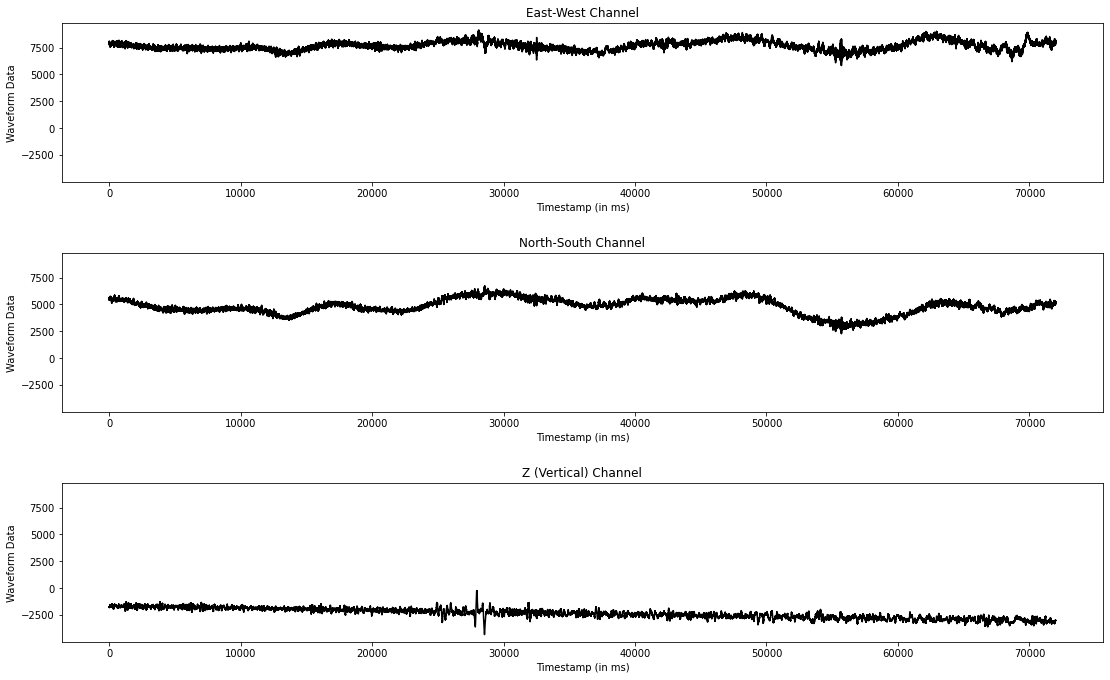

In [118]:
print('Raw Data Wavelength')
print(f'delta time: {channel_delta_list[0]} | frequency (Hz): {1/channel_delta_list[0]}')
plot_channel_waveform(full_channel_list[0], waveform_max=full_channel_list[0].shape[0])

### Detrend Wavelength data

In [119]:
test_wavelength = full_channel_list[0].copy()
# print(test_wavelength)

test_wavelength_mean_detrend = signal.detrend(test_wavelength, type='constant', axis=0)
# print(test_wavelength_mean_detrend)

test_wavelength_linear_detrend = signal.detrend(test_wavelength, type='linear', bp=0, axis=0)
# print(test_wavelength_linear_detrend)

test_wavelength_bplinear_detrend = signal.detrend(test_wavelength, type='linear', bp=test_wavelength.shape[0]//2, axis=0)
# print(test_wavelength_bp_detrend)

# index_channel = [2]
# print('normal waveform')
# plot_channel_waveform(test_wavelength, waveform_max=test_wavelength.shape[0], index_channel=index_channel)
# print('\nmean detrend waveform')
# plot_channel_waveform(test_wavelength_mean_detrend, waveform_max=test_wavelength_mean_detrend.shape[0], index_channel=index_channel)
# print('\nlinear detrend waveform')
# plot_channel_waveform(test_wavelength_linear_detrend, waveform_max=test_wavelength_linear_detrend.shape[0], index_channel=index_channel)
# print('\nlinear detrend with breakpoint waveform')
# plot_channel_waveform(test_wavelength_bp_detrend, waveform_max=test_wavelength_bp_detrend.shape[0], index_channel=index_channel)

mean data:
-0.0011545139
0.0011119791
-0.0006293403


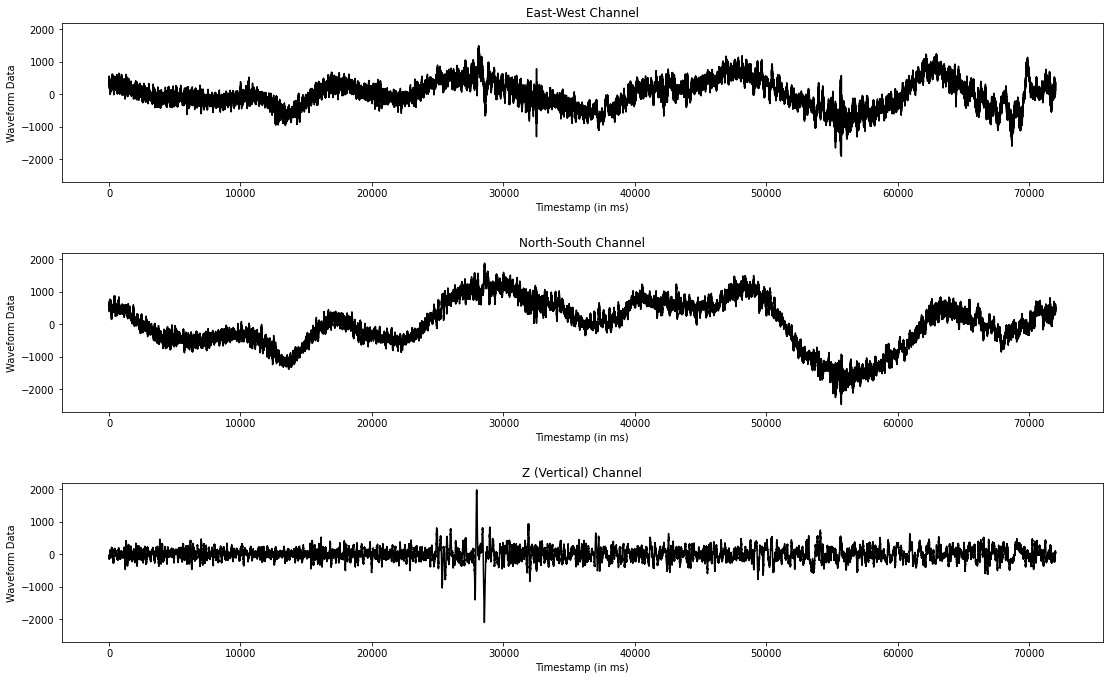

In [120]:
full_channel_list_detrend = full_channel_list.copy()
temp_list = np.empty((3,))

for i in range(len(full_channel_list_detrend)):
    full_channel_list_detrend[i] = signal.detrend(full_channel_list_detrend[i], type='linear', axis=0)


test_plot_data = full_channel_list_detrend[0]
print('mean data:')
for i in range(3):
    print(test_plot_data[:, i].mean())
plot_channel_waveform(test_plot_data, waveform_max=test_plot_data.shape[0])

In [121]:
test_plot_data.shape

(72000, 3)

### Use Filter

low-pass: 0.001 | high-pass: 0.01


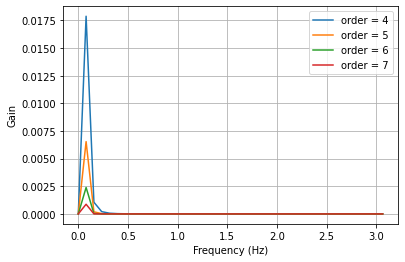

In [122]:
# for order in range(1, 10, 2):
for index, order in enumerate([4, 5, 6, 7]):
    fs = 100
    lowcut, highcut = 0.001, 0.01
    
    if index==0:
        print(f'low-pass: {lowcut} | high-pass: {highcut}')
    sos = signal.butter(order, [lowcut, highcut], btype='bandpass', output='sos')
    w, h = signal.sosfreqz(sos, worN=40)
    
    plt.plot(w, abs(h), label="order = %d" % order)
    
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')
    
plt.show()

min: -1165.735107421875
max: 1540.2769775390625
mean: 0.12339341640472412


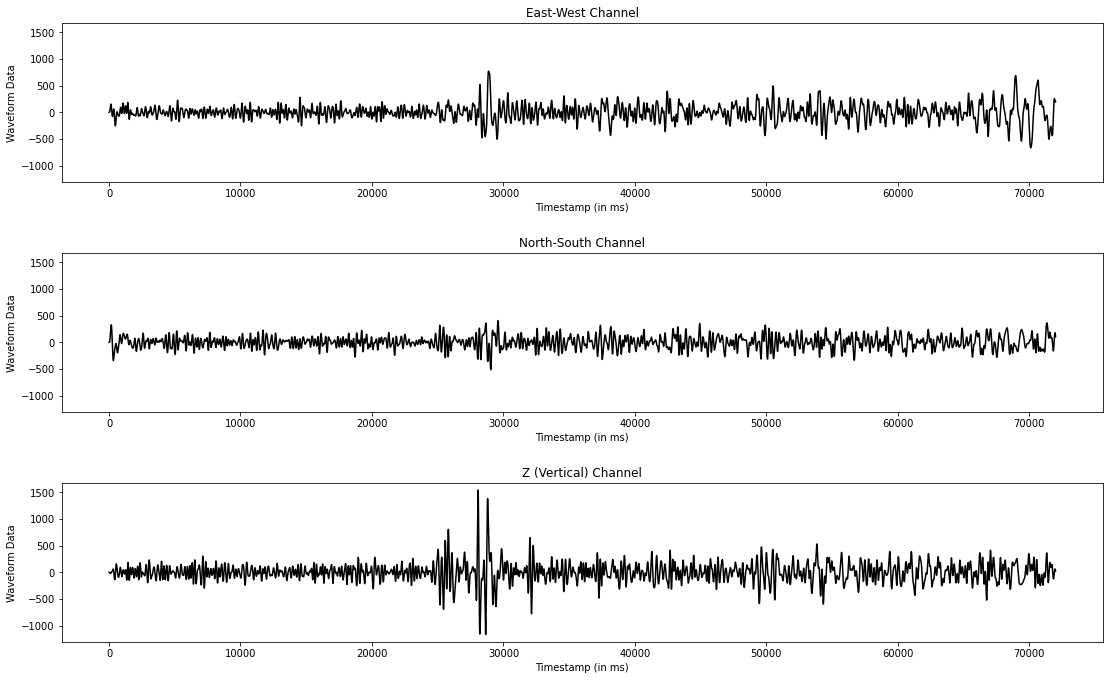

In [123]:
from copy import deepcopy
full_channel_list_detrend_bandpass = deepcopy(full_channel_list_detrend)

for i in range(len(full_channel_list_detrend_bandpass)):
#     sos = signal.butter(5, [0.1, 0.7],  btype='bandpass', output='sos')
    sos = signal.butter(5, [0.001, 0.01], btype='bandpass', output='sos')
    for j in range(3):   
        full_channel_list_detrend_bandpass[i][:, j] = signal.sosfilt(sos, full_channel_list_detrend_bandpass[i][:, j])

test_plot_data = full_channel_list_detrend_bandpass[0].copy()
print(f'min: {test_plot_data[:, 2].min()}')
print(f'max: {test_plot_data[:, 2].max()}')
print(f'mean: {test_plot_data[:, 2].mean()}')
plot_channel_waveform(test_plot_data, waveform_max=test_plot_data.shape[0])

In [124]:
# for i in range(10):
#     print('raw data')
#     print(f'max: {full_channel_list[i][:, 2].max()} | min: {full_channel_list[i][:, 2].min()} | mean: {full_channel_list[i][:, 2].mean()}')
#     plot_channel_waveform(full_channel_list[i], waveform_max=full_channel_list[i].shape[0], index_channel=[2])
#     print('after detren + band-pass filter')
#     print(f'max: {full_channel_list_detrend_bandpass[i][:, 2].max()} | min: {full_channel_list_detrend_bandpass[i][:, 2].min()} | mean: {full_channel_list_detrend_bandpass[i][:, 2].mean()}')
#     plot_channel_waveform(full_channel_list_detrend_bandpass[i], waveform_max=full_channel_list_detrend_bandpass[i].shape[0], index_channel=[2])
#     print('============================================================')

In [125]:
test_plot_data.shape

(72000, 3)

### Resample Data to 100 Hz

[[ 1.3888889e-05 -1.7361111e-06  0.0000000e+00]
 [-2.8440334e+01 -1.4914410e+01 -3.4167778e+00]
 [-1.3096014e+01 -6.8605661e+00 -1.5706806e+00]
 ...
 [ 2.2249101e+02  1.1832251e+02  2.7353779e+01]
 [ 1.6754469e+02  8.8532425e+01  2.0382278e+01]
 [ 7.7478149e+01  4.0786377e+01  9.3671112e+00]]


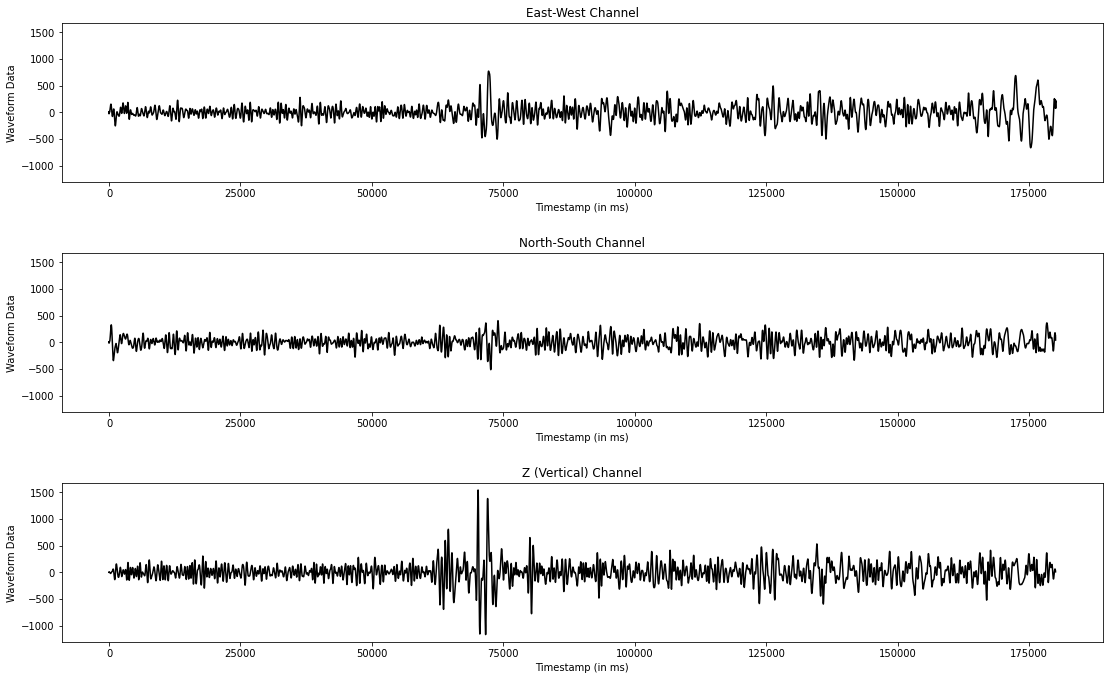

In [126]:
full_channel_list_detrend_resample100hz = [np.empty((180000, 3))] * len(full_channel_list_detrend_bandpass)

total_30mins_100hz_data = 100 * 60 * 30
for i in range(len(full_channel_list_detrend_resample100hz)):
    full_channel_list_detrend_resample100hz[i] = signal.resample(full_channel_list_detrend_bandpass[i], total_30mins_100hz_data)

test_plot_data = full_channel_list_detrend_resample100hz[0]
print(test_plot_data)
plot_channel_waveform(test_plot_data, waveform_max=test_plot_data.shape[0])

In [127]:
test_plot_data.shape

(180000, 3)

### Wavelet Denoising

In [128]:
def wavelet_denoising(data, thresholding_method='BayesShrink', wavelet_name='db1'):
    def BayesShrink():
        im_bayes = denoise_wavelet(data, wavelet=wavelet_name,
                                   channel_axis=-1,
                                   method='BayesShrink', mode='soft', wavelet_levels=4,
                                   rescale_sigma=True)
        return im_bayes
    
    def VisuShrink():
        sigma_est = estimate_sigma(data, channel_axis=-1, average_sigmas=True)
        im_visu = denoise_wavelet(data, wavelet=wavelet_name,
                                  channel_axis=-1,
                                  method='VisuShrink', mode='soft', wavelet_levels=4,
                                  sigma=sigma_est, rescale_sigma=True)
        
        return im_visu
    
    if thresholding_method == 'BayesShrink':
        return BayesShrink()
    elif thresholding_method == 'VisuShrink':
        return VisuShrink()

[[-5.7220459e-06  3.8146973e-06  5.7220459e-06]
 [-8.2054535e+01  7.1544304e+01  4.0671021e+02]
 [-3.7807850e+01  3.2958504e+01  1.8720378e+02]
 ...
 [ 6.3629187e+02 -5.5632770e+02 -3.1987388e+03]
 [ 4.8110626e+02 -4.2010803e+02 -2.4029695e+03]
 [ 2.2300529e+02 -1.9458652e+02 -1.1096149e+03]]


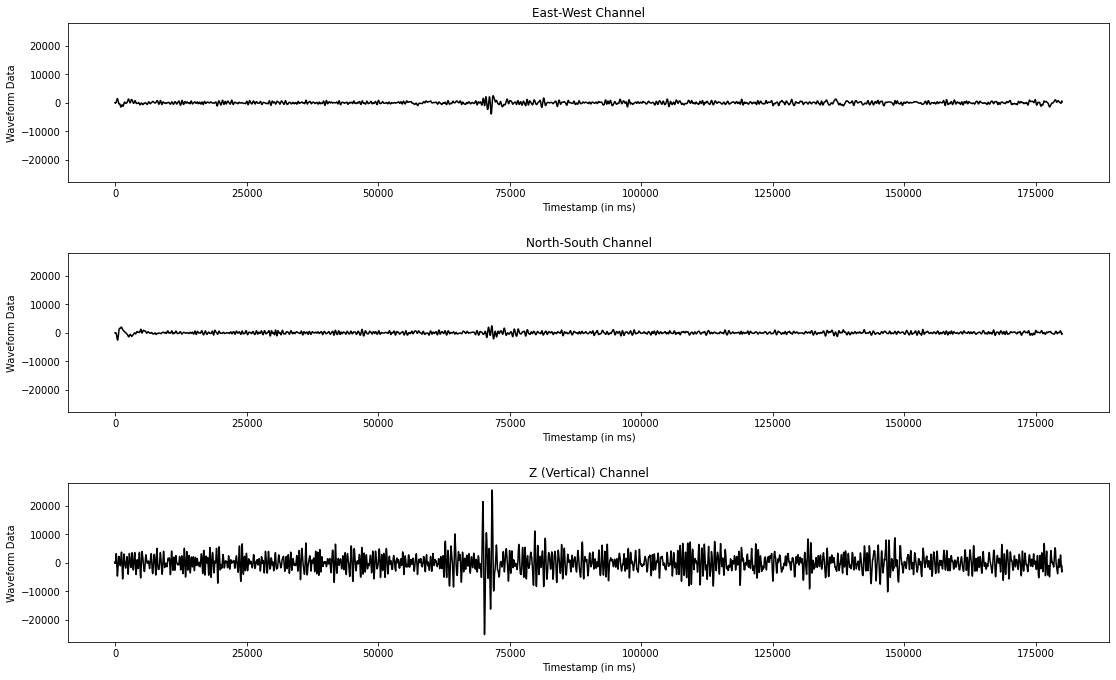

In [129]:
full_channel_list_full_processing = [np.empty(full_channel_list_detrend_resample100hz[0].shape)] * len(full_channel_list_detrend_resample100hz)

for i in range(len(full_channel_list_full_processing)):
    full_channel_list_full_processing[i] = wavelet_denoising(full_channel_list_detrend_resample100hz[i], wavelet_name='db6')
test_plot_data = full_channel_list_full_processing[1]
print(test_plot_data)
plot_channel_waveform(test_plot_data, waveform_max=test_plot_data.shape[0])

In [130]:
full_data_wavelength = np.array(full_channel_list_full_processing)
# print(full_data_wavelength)
full_data_wavelength.shape

(60, 180000, 3)

### Create Metadata File As CSV

In [131]:
wavelength_dict

{'BK.CMB_Q.2022.136.190418': ['00', ['BHE', 'BHN', 'BHZ']],
 'CI.PASC_D.2022.136.190432': ['00', ['BHE', 'BHN', 'BHZ']],
 'CU.GRTK_M.2022.136.190824': ['00', ['BH2', 'BH1', 'BHZ']],
 'GT.VNDA_M.2022.136.190024': ['00', ['BHE', 'BHN', 'BHZ']],
 'IC.ENH_M.2022.136.185526': ['00', ['BH2', 'BH1', 'BHZ']],
 'IC.HIA_M.2022.136.185806': ['00', ['BH2', 'BH1', 'BHZ']],
 'IC.KMI_M.2022.136.185435': ['00', ['BH2', 'BH1', 'BHZ']],
 'IC.SSE_M.2022.136.185603': ['00', ['BH2', 'BH1', 'BHZ']],
 'IC.XAN_M.2022.136.185556': ['00', ['BH2', 'BH1', 'BHZ']],
 'II.ASCN_M.2022.136.190315': ['00', ['BH2', 'BH1', 'BHZ']],
 'II.BFO_M.2022.136.190151': ['00', ['BHE', 'BHN', 'BHZ']],
 'II.BORG_M.2022.136.190245': ['00', ['BH2', 'BH1', 'BHZ']],
 'II.BORK_M.2022.136.185857': ['10', ['BH2', 'BH1', 'BHZ']],
 'II.CMLA_M.2022.136.190347': ['00', ['BH2', 'BH1', 'BHZ']],
 'II.COCO_M.2022.136.185028': ['00', ['BH2', 'BH1', 'BHZ']],
 'II.DGAR_M.2022.136.185426': ['10', ['BH2', 'BH1', 'BHZ']],
 'II.EFI_M.2022.136.190339': ['

In [190]:
df_sac_wavelength_adddata['trace_name'] = ''
index_drop_list = []

for i in range(len(df_sac_wavelength_adddata)):
    filename_df = str(df_sac_wavelength_adddata.loc[i, 'Net'] + '.' + df_sac_wavelength_adddata.loc[i, 'Station'])
    
    if filename_df in '\n'.join(wavelength_dict.keys()):
        temp = [filename for filename in list(wavelength_dict.keys()) if filename_df in filename]
        df_sac_wavelength_adddata.loc[i, 'trace_name'] = temp[0]
    else:
        index_drop_list.append(i)

df_sac_wavelength_adddata = df_sac_wavelength_adddata.drop(index_drop_list).reset_index(drop=True)
df_sac_wavelength_adddata

,Station,Source,Net,Station_Latitude,Station_Longitude,Distance,Azimuth,Elevation,Station Name,Start_Time,Station_Elevation,Station_Depth,Earthquake_Latitude,Earthquake_Longitude,Earthquake_Depth,Earthquake_Station_Distance,Back_Azimuth,trace_name
0,COCO,IRISDMC,II,-12.190100,96.834900,8.622234,-143.996826,1.0,"West Island, Cocos (Keeling) Islands",2022-05-16T18:50:28.019538Z,1.000000,44.799999,-5.245,102.007698,23.0,954.800049,36.965694,II.COCO_M.2022.136.185028
1,KAPI,IRISDMC,II,-5.014200,119.751700,17.673860,90.057363,300.0,"Kappang, Sulawesi, Indonesia",2022-05-16T18:52:29.019538Z,300.000000,61.000000,-5.245,102.007698,23.0,1965.260376,268.468445,II.KAPI_M.2022.136.185229
2,MBWA,IRISDMC,IU,-21.159000,119.731300,23.422910,134.423008,190.0,"Marble Bar, Western Australia",2022-05-16T18:53:32.019538Z,93.000000,97.000000,-5.245,102.007698,23.0,2597.827881,310.139557,IU.MBWA_M.2022.136.185332
3,CHTO,IRISDMC,IU,18.814100,98.944300,24.247711,-7.075346,420.0,"Chiang Mai, Thailand",2022-05-16T18:53:40.019538Z,320.000000,100.000000,-5.245,102.007698,23.0,2679.332520,172.510071,IU.CHTO_M.2022.136.185340
4,DAV,IRISDMC,IU,7.069700,125.579100,26.551312,62.599605,151.0,"Davao, Philippines",2022-05-16T18:54:01.019539Z,150.000000,1.000000,-5.245,102.007698,23.0,2948.098145,243.135620,IU.DAV_M.2022.136.185401
5,DGAR,IRISDMC,II,-7.412100,72.452500,29.449051,-95.791232,1.0,"Diego Garcia, Chagos Islands, Indian Ocean",2022-05-16T18:54:26.019538Z,1.000000,2.000000,-5.245,102.007698,23.0,3274.596924,87.556671,II.DGAR_M.2022.136.185426
6,KMI,IRISDMC,IC,25.123300,102.740000,30.376645,1.311222,1975.0,"Kunming, Yunnan Province, China",2022-05-16T18:54:35.019538Z,1940.000000,35.000000,-5.245,102.007698,23.0,3357.289062,181.450165,IC.KMI_M.2022.136.185435
7,WRAB,IRISDMC,II,-19.933600,134.360000,34.714212,117.948625,366.0,"Tennant Creek, NT, Australia",2022-05-16T18:55:13.019538Z,366.000000,100.000000,-5.245,102.007698,23.0,3856.875977,290.541412,II.WRAB_M.2022.136.185513
8,ENH,IRISDMC,IC,30.276200,109.494400,36.237915,10.973301,500.0,"Enshi, Hubei Province, China",2022-05-16T18:55:26.019538Z,500.000000,0.000000,-5.245,102.007698,23.0,4007.337891,192.740921,IC.ENH_M.2022.136.185526
9,XAN,IRISDMC,IC,34.031300,108.923700,39.816663,8.965650,630.0,"Xi'an, China",2022-05-16T18:55:56.019538Z,630.000000,0.000000,-5.245,102.007698,23.0,4403.910645,190.841858,IC.XAN_M.2022.136.185556


### Create NPZ File To Feed Into Model

In [198]:
len(wavelength_dict)
wavelength_dict[0]

KeyError: 0

In [195]:
full_data_wavelength.shape

(60, 180000, 3)

In [204]:
full_data_wavelength[0].shape

(180000, 3)

In [244]:
# for key, signal in npz_dict.items():
#     print(f'key: {key}')
#     plot_channel_waveform(signal, waveform_max=signal.shape[0], index_channel=[2])
#     print('=========================================================')

In [208]:
npz_dict = {}
for index, (key, _) in enumerate(wavelength_dict.items()):
#     print(index)
#     print(key)
#     print(item)
#     print('-=============-')
    npz_dict[key] = full_data_wavelength[index]

npz_dict

{'BK.CMB_Q.2022.136.190418': array([[ 1.21593475e-05, -2.98023224e-06,  0.00000000e+00],
        [-2.84403343e+01, -1.49144087e+01, -3.41677761e+00],
        [-1.30960140e+01, -6.86056519e+00, -1.57068002e+00],
        ...,
        [ 2.22491028e+02,  1.18322502e+02,  2.73537807e+01],
        [ 1.67544708e+02,  8.85324097e+01,  2.03822765e+01],
        [ 7.74781418e+01,  4.07863617e+01,  9.36710835e+00]], dtype=float32),
 'CI.PASC_D.2022.136.190432': array([[-5.7220459e-06,  3.8146973e-06,  5.7220459e-06],
        [-8.2054535e+01,  7.1544304e+01,  4.0671021e+02],
        [-3.7807850e+01,  3.2958504e+01,  1.8720378e+02],
        ...,
        [ 6.3629187e+02, -5.5632770e+02, -3.1987388e+03],
        [ 4.8110626e+02, -4.2010803e+02, -2.4029695e+03],
        [ 2.2300529e+02, -1.9458652e+02, -1.1096149e+03]], dtype=float32),
 'CU.GRTK_M.2022.136.190824': array([[ 1.62124634e-05,  4.00543213e-05, -2.57492065e-05],
        [-2.11305786e+02,  4.61381264e+01, -5.46764412e+01],
        [-9.729064

In [89]:
# np.savez_compressed('./Data/data_wavelength.npz', full_data_wavelength)
with open('./Data/data_wavelength.json', 'wb') as fp:
    pickle.dump(npz_dict, fp)

# Earthquake Detection Visualization

In [24]:
df_visualize = df_sac_wavelength_adddata.sort_values(by=['Earthquake_Station_Distance'])
df_visualize.head(12)

,Station,Source,Net,Station_Latitude,Station_Longitude,Distance,Azimuth,Elevation,Station Name,Start_Time,Station_Elevation,Station_Depth,Earthquake_Latitude,Earthquake_Longitude,Earthquake_Depth,Earthquake_Station_Distance,Back_Azimuth
1,COCO,IRISDMC,II,-12.1901,96.8349,8.622234,-143.996826,1.0,"West Island, Cocos (Keeling) Islands",2022-05-16T18:50:28.019538Z,1.0,44.799999,-5.245,102.007698,23.0,954.800049,36.965694
2,KAPI,IRISDMC,II,-5.0142,119.7517,17.673860,90.057363,300.0,"Kappang, Sulawesi, Indonesia",2022-05-16T18:52:29.019538Z,300.0,61.000000,-5.245,102.007698,23.0,1965.260376,268.468445
3,MBWA,IRISDMC,IU,-21.1590,119.7313,23.422910,134.423008,190.0,"Marble Bar, Western Australia",2022-05-16T18:53:32.019538Z,93.0,97.000000,-5.245,102.007698,23.0,2597.827881,310.139557
4,CHTO,IRISDMC,IU,18.8141,98.9443,24.247711,-7.075346,420.0,"Chiang Mai, Thailand",2022-05-16T18:53:40.019538Z,320.0,100.000000,-5.245,102.007698,23.0,2679.332520,172.510071
5,DAV,IRISDMC,IU,7.0697,125.5791,26.551312,62.599605,151.0,"Davao, Philippines",2022-05-16T18:54:01.019539Z,150.0,1.000000,-5.245,102.007698,23.0,2948.098145,243.135620
6,DGAR,IRISDMC,II,-7.4121,72.4525,29.449051,-95.791232,1.0,"Diego Garcia, Chagos Islands, Indian Ocean",2022-05-16T18:54:26.019538Z,1.0,2.000000,-5.245,102.007698,23.0,3274.596924,87.556671
7,KMI,IRISDMC,IC,25.1233,102.7400,30.376645,1.311222,1975.0,"Kunming, Yunnan Province, China",2022-05-16T18:54:35.019538Z,1940.0,35.000000,-5.245,102.007698,23.0,3357.289062,181.450165
8,WRAB,IRISDMC,II,-19.9336,134.3600,34.714212,117.948625,366.0,"Tennant Creek, NT, Australia",2022-05-16T18:55:13.019538Z,366.0,100.000000,-5.245,102.007698,23.0,3856.875977,290.541412
9,ENH,IRISDMC,IC,30.2762,109.4944,36.237915,10.973301,500.0,"Enshi, Hubei Province, China",2022-05-16T18:55:26.019538Z,500.0,0.000000,-5.245,102.007698,23.0,4007.337891,192.740921
10,XAN,IRISDMC,IC,34.0313,108.9237,39.816663,8.965650,630.0,"Xi'an, China",2022-05-16T18:55:56.019538Z,630.0,0.000000,-5.245,102.007698,23.0,4403.910645,190.841858


In [25]:
earthquake_lattitude = df_visualize['Earthquake_Latitude'].unique()[0]
earthquake_longitude = df_visualize['Earthquake_Longitude'].unique()[0]

In [26]:
list_data_station = []
# random_index = np.random.randint(0, 62, size=(3))
for i in range(3):
    list_data_station.append(df_visualize.iloc[i])

In [27]:
earthquake_map = folium.Map(location=[earthquake_lattitude, earthquake_longitude], zoom_start=3, zoom_control=False)
folium.Marker(location=[earthquake_lattitude, earthquake_longitude],
              popup='Earthquake Location',
              icon=folium.Icon(color='red')).add_to(earthquake_map)

for i in range(3):
#     print(list_data_station[i])
    station_temp = list_data_station[i]['Station']
#     folium.Marker(location=[list_data_station[i]['Station_Latitude'], list_data_station[i]['Station_Longitude']],
#               popup=f'Station {station_temp}',
#               icon=folium.Icon(color='blue')).add_to(earthquake_map)
    folium.Circle(location=[list_data_station[i]['Station_Latitude'], list_data_station[i]['Station_Longitude']], 
                  radius=list_data_station[i]['Earthquake_Station_Distance']*1000,
                  popup=f'Station {station_temp}', fill=True).add_to(earthquake_map)

earthquake_map

In [28]:
df_visualize.to_csv('./Data/data_temp.csv', index=False)

# Tensorflow Pipeline